# MEL Survey Analysis Project

#### Data Analyst: Allen Hu (GRID3; Research Asisstant)

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
import seaborn as sns
import datetime
import plotly.express as px

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import set_config
from sklearn.model_selection import GridSearchCV

from scipy.stats import chisquare
from scipy.stats import ttest_ind

from tqdm import tqdm

from yellowbrick.cluster import KElbowVisualizer

set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

GRID3_COLORSCALE = ['#b95019','#d27c2f','#e9a64c','#ffd16f']
GRID3_ORANGE = '#b95019'
GRID3_PALE = '#ffd16f'

# Overview

In this notebook, I will provide an overview of the survey responses through data visualization. In particular, I will provide visualizations and comments for each of the questions outlined in the survey. In addition, due to the signal being quite weak during my first round of analysis (full aggregates and averages), I will also utilize a clustering technique (hierarchical clustering) which will help us 'remove' some of the responses which do not give a lot of information due to their low variance. I will call those responses with low variance (and generally very high scores overall) "Fans", which make up about 24% of the sample. The other group (known as the "Critics") has much more variation in their responses and thus provides us with richer information on how the product is used, what are some painpoints, and how can we address them to best generate value. In the following sections, I will first clean the data, run a clustering technique, and visualze the survey responses while providing my own comments along the way. If you have any questions please feel free to reach out to me on WhatsApp (773-999-2601) or email (yh3468@columbia.edu)

#### Note: Text data is currently only described and not visualized

### Cleaning Texts and Dates

In [2]:
raw_df = pd.read_excel("mel_survey_data_analysis.xlsx")

In [3]:
#country
raw_df.iloc[:,0] = raw_df.iloc[:,0].apply(lambda x: x.lower())
#combining the same object encoded differently
raw_df.iloc[:,0] = raw_df.iloc[:,0].replace("guinée","guinee conakry")


replace_dict = {'I (or my organization) am working or have previously worked with GRID3 on a project':"Worked or Working w/ GRID3",
               'I (or my organization) have not worked with GRID3 on a project':"Have Not Worked w/ GRID3"}

raw_df.loc[:,'Which of the following best characterizes your relationship with GRID3?'].replace(replace_dict,inplace=True)

In [4]:
def word_to_ranking(string):
    """
    Converts string such as "strongly agree" to values
    """
    if isinstance(string,str):    
        string = string.lower()
        if string in ['strongly agree','always','very likely','excellent','extremely useful','Extremely accurate']:
            return 5
        elif string in ['agree','likely','very good','mostly','moderately useful','moderately accurate']:
            return 4
        elif string in ['neutral','good','partially','moderately useful','somewhat accurate','unsure','not sure']:
            return 3
        elif string in ['disagree','fair','occasionally','slightly useful','slightly accurate','unlikely']:
            return 2
        elif string in ['strongly disagree','poor','never','not useful at all','not accurate at all','very unlikely']:
            return 1
        else:
            return string
    else:
        return string
    
def get_score_from_string(string):
    """
    Get the score from a string
    """
    
    if isinstance(string,str):
        try:
            return int(string[0])
        except:
            print(string)
    else:
        return string
    
def check_clusters(data,labels,label_names):
    
    #print(list(zip(*np.unique(labels,return_counts=True))))
    # pivot_table() calculates the mean by default
    return pd.DataFrame(data.groupby(labels).agg(['mean'])).rename(index=label_names)

def pop_std(x):
    return x.std(ddof=0)

In [5]:
lst_ranking = [15,16] + list(range(63,85)) + list(range(90,101)) + [116]

for i in lst_ranking:
    raw_df.iloc[:,i] = raw_df.iloc[:,i].apply(lambda x: word_to_ranking(x))
    raw_df.iloc[:,i] = raw_df.iloc[:,i].apply(lambda x: get_score_from_string(x))

In [6]:
ranking_df = raw_df.iloc[:,lst_ranking]

In [7]:
ranking_df.drop(['Please rate your agreement/disagreement with the following statements.1'],axis=1,inplace=True)

## Defining Clustering Pipelines

These pipelines are constructed to make heirarchical clustering groups. This is meant to 'remove' the effect of individuals with extreme responses so that we can also see more clearly the signal from more critical users.

In [8]:
#heir_params = {'scalar':[StandardScaler(),Normalizer()],
#                 'model__linkage':['ward','average','complete','single']}

numerical_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', numerical_pipe, ranking_df.columns)])

model_km = KMeans(n_clusters=5,random_state=1229)
kelbow = KElbowVisualizer(model_km, k=(1,12))

kmeans_pipe = Pipeline([
    ('preprocessors',preprocessing),
    ('model',model_km)])

#kmeans_grid = GridSearchCV(

#---

model_heir = AgglomerativeClustering(n_clusters=3,compute_distances=True)

heir_pipe = Pipeline([
    ('preprocessors',preprocessing),
    ('model',model_heir)])

#heir_grid = GridSearchCV(heir_pipe, heir_params).fit(ranking_df)

#Get best params
#best_params = heir_grid.best_params_
#print(best_params)
#best_pipe = heir_grid.best_estimator_
#print(best_pipe)

kmeans_clusters = kmeans_pipe.fit(ranking_df)
heir_clusters = model_heir.fit(ranking_df)

#display(heir_clusters)

#NOTE: model is sensitive to initial random state

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
labels_hier = model_heir.labels_
cluster_names = {0:'Super Fans',2:'Satisfied Majority'}

We see a small group (29) of "Fans" that are significantly different than the rest of the sample in their responses, with a large group of critical individuals (105), and 3 outliers that are not representative of the general trend, thus will not take into too much consideration in cluster analysis.

#### Heirarchical Dendrogram

This is used to visualize all the potential clusters that we can choose in this dataset, the Y-axis is the degree of difference between groups (euclidian difference), the X-axis is the indicator of either the index of the individual if it is a singleton cluster, or (number of users in the cluster) if the number is bracketed. Each "joining" of two vertical lines shows when two clusters can now be categorized under the same category.

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    plt.title("Degree of difference between each user cluster")
    plt.ylabel("Degree of difference")
    plt.xlabel("Index of user (without brackets) OR Number of users (with brackets)")

In [ ]:
plot_dendrogram(heir_clusters.named_steps['model'], truncate_mode="level", p=3)

#see which people are from the same cluster 
# note that some people are more satisifed with location than others 

### Test whether the two main groups have a statistically significant difference

In [ ]:
res = ttest_ind(check_clusters(ranking_df,labels_hier,cluster_names).T[['Super Fans']].values.flatten(),check_clusters(ranking_df,labels_hier,cluster_names).T[['Satisfied Majority']].values.flatten())

In [ ]:
alpha = 0.05
if res[1] < alpha:
    print("Significantly Different")

Running a t-test, we are able to see that the difference between the two main segments "Fans" and "Critics", are indeed statistically significant.

### Note: The two groups are  significantly different (statistically), then who are the two groups?

In [10]:
labels_col = pd.concat([pd.DataFrame([ele],columns=['labels']) for ele in labels_hier],ignore_index=True)
labels_col = labels_col.replace({0:"Super Fans",2:"Satisfied Majority"})
ranking_df.loc[:,'labels'] = labels_col
irrelevant_idx = ranking_df[ranking_df.loc[:,'labels']==1].index
ranking_df.drop(irrelevant_idx,inplace=True)

NameError: name 'labels_hier' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


labels
Satisfied Majority    3.943506
Super Fans            4.639861
dtype: float64


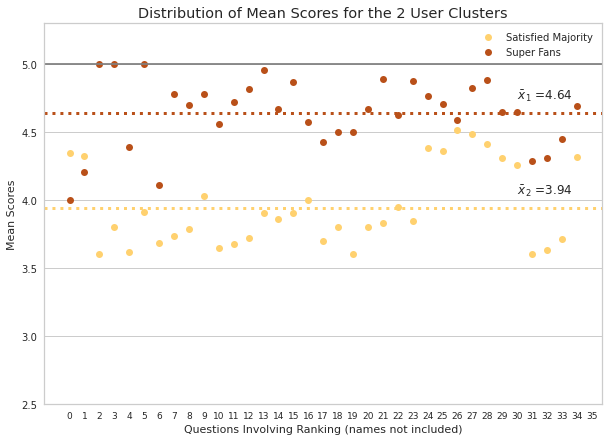

In [18]:
fig, ax = plt.subplots(figsize=(10,7))

plotting = ranking_df.groupby('labels').mean().T
plotting.plot(style=['o','o'],ax=ax,color=[GRID3_PALE,GRID3_ORANGE])

print(plotting.mean())

ax.set_xticks([x for x in range(ranking_df.shape[1])])
ax.set_xticklabels([x for x in range(ranking_df.shape[1])],fontsize=9)
ax.set_ylim([2.5,5.3])
ax.grid(axis='x')
for row,color,var in zip(plotting.mean(),[GRID3_PALE,GRID3_ORANGE],['x_2','x_1']):
    ax.axhline(row,color=color,ls=':',lw=3)
    ax.text(30,row+.1,fr'$\bar{var}$'+(f" ={round(row,2)}"))
ax.set_xlabel("Questions Involving Ranking (names not included)")
ax.set_ylabel("Mean Scores")
ax.set_title("Distribution of Mean Scores for the 2 User Clusters",fontsize=14.5,font='DejaVu Sans')
ax.axhline(5,color='gray',ls="-")
plt.legend()
fig.savefig('clusters.png')

#### Step 1: create identification DF:

Sanity Check complete, the labels are assigned correctly

In [9]:
lst_all_col = list(range(raw_df.shape[1]))
identification_cols = set(lst_all_col).difference(set(lst_ranking)) #anything not in ranking will be in identification
identification_df = raw_df.iloc[:,list(identification_cols)]
identification_df = identification_df.join(labels_col)
identification_df = identification_df.drop(columns=['_submitted_by','_tags','_index','_status'])

NameError: name 'labels_col' is not defined

We find that in general, the majority of our users come from (in decending order) Nigeria, Zambia DRC, Berkina Faso, and Sierra Leone. Beyond the aggregates, notice that the majority of composition of individuals change when we look at critical users vs. fans. In particular, Fans generally come from (in decending order) Zambia, the DRC, and Nigeria. However, in the 'critical users' case, the most prominent majority of users is Nigeria, followed by the DRC and Zambia. This shows that the location of the individual is associated with how critical individuals are with GRID3.

### Visualizing using maps

In [20]:
groups = identification_df.groupby('labels')
_,majority_df,fans_df = [groups.get_group(x) for x in groups.groups]

In [21]:
def get_graphing_df(column_idx,fill_zero=False):
    import functools as ft
    lst_dfs = []
    
    if fill_zero:
        lst_dfs.append(identification_df.iloc[:,column_idx].value_counts().reindex(identification_df.iloc[:,column_idx].unique(), fill_value=0))
        lst_dfs.append(fans_df.iloc[:,column_idx].value_counts().reindex(identification_df.iloc[:,column_idx].unique(), fill_value=0))
        lst_dfs.append(majority_df.iloc[:,column_idx].value_counts().reindex(identification_df.iloc[:,column_idx].unique(), fill_value=0))
    else:
        lst_dfs.append(identification_df.iloc[:,column_idx].value_counts())
        lst_dfs.append(fans_df.iloc[:,column_idx].value_counts())
        lst_dfs.append(majority_df.iloc[:,column_idx].value_counts())
    
    ret_df = ft.reduce(lambda l,r: pd.merge(l,r,right_index=True,left_index=True),lst_dfs)
    
    #cleaning ret_df
    ret_df.columns = ["Total","Majority","Fans"]
    
    return ret_df

In [24]:
country_counts_agg = identification_df.iloc[:,0].value_counts()
country_counts_fans = fans_df.iloc[:,0].value_counts()
country_counts_majority = majority_df.iloc[:,0].value_counts()

In [25]:
pop_sample = pd.merge(country_counts_agg,country_counts_fans,left_index=True,right_index=True)
pop_sample = pd.merge(pop_sample,country_counts_majority,left_index=True,right_index=True)

In [26]:
def get_stacked_bars(ax,segment_df,x_name,y_name,title,upper=False,ylim=[0,135]):
    
    if upper:
        labs = [f'{x}'.upper().strip() for x in segment_df.index]
    else:
        labs = [f'{x}'.strip() for x in segment_df.index]

    ax.bar(labs, segment_df.iloc[:,2], label='Satisfied Majority',color=GRID3_PALE)
    ax.bar(labs, segment_df.iloc[:,1], label='Super Fans',bottom=segment_df.iloc[:,2],color=GRID3_ORANGE)

    ax.set_ylabel(y_name)
    ax.set_xlabel(x_name)
    ax.set_title(title)
    ax.grid(axis='x')
    ax.set_ylim(ylim)
    ax.legend()
    
 
    return ax

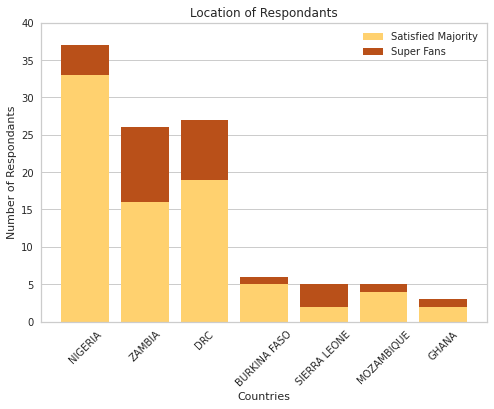

In [27]:
fig, ax = plt.subplots()

ax = get_stacked_bars(ax,pop_sample,'Countries','Number of Respondants','Location of Respondants',True,[0,40])

#ax.set_xticklabels(rotation=45)
plt.xticks(rotation=45)
plt.savefig('respondants.png')
plt.show()

In [28]:
identification_df.iloc[:,2].value_counts()

Worked or Working w/ GRID3    95
Have Not Worked w/ GRID3      42
Name: Which of the following best characterizes your relationship with GRID3?, dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


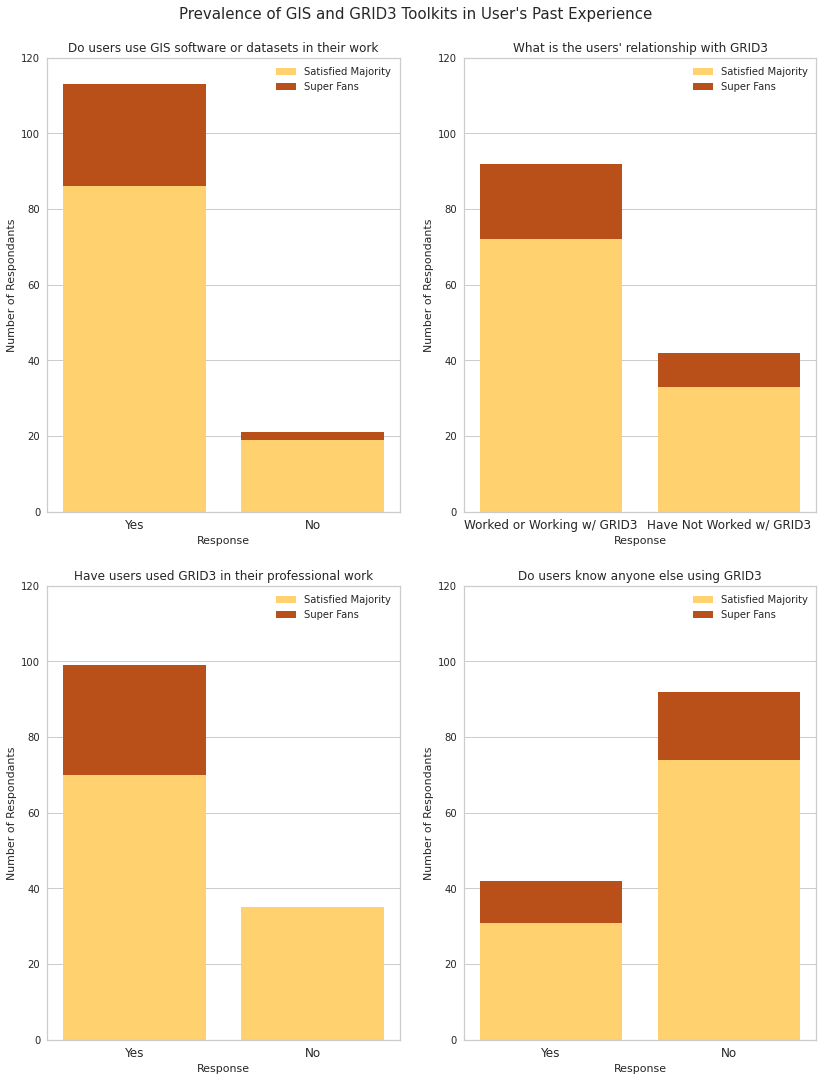

In [29]:
# GRAPHING ORIGINAL PIE PLOTS
fig, axes = plt.subplots(2,2,figsize=(12,15))
graphing_dfs = []
graphing_dfs.extend([get_graphing_df(idx,togg) for idx,togg in [(1,False),(2,False),(45,True),(82,False)]])
graphing_dfs[3] = graphing_dfs[3][::-1]
titles = []
titles.append(["Response","Number of Respondants","Do users use GIS software or datasets in their work"])
titles.append(["Response","Number of Respondants","What is the users' relationship with GRID3"])
titles.append(["Response","Number of Respondants","Have users used GRID3 in their professional work"])
titles.append(["Response","Number of Respondants","Do users know anyone else using GRID3"])

for i,ax in enumerate(axes.ravel()):
    ax = get_stacked_bars(ax,graphing_dfs[i],*titles[i],ylim=[0,120])
    ax.tick_params('x',labelrotation=0,labelsize='medium')  
    
plt.tight_layout(pad=2)
plt.suptitle("Prevalence of GIS and GRID3 Toolkits in User's Past Experience",fontsize=15,y=1.01)
plt.show()

## Do you use geospatial software, are you working (or have worked) with GRID3, and do you know anyone outside that also uses GRID3?

Going row by row...
1. Notice first that the majority of individuals who uses GRID3 products have expereince working with geospatial software and datasets. In particular, the overwhelming majority of fans have used geospatial software before, where as there is a the proportion of critical users are (very slightly) less familiar with geospatial software. 
2. We find that on average, approximately 70% of all users have used GRID3 products regardless of overall aggregate or clustered groups.
3. We find that on average, there is approximately 30% of all users who know individuals outside of their organization using GRID3-supported products. It is worth noting, however, that amongst the "Fans", this percentage is closer to 40%.
4. Finally, about $\frac{3}{4}$ of all users actually used GRID3 supported products in their work. It is worth noting that all of the 'Fans' (29) used GRID3-supported products, whereas almost $\frac{1}{3}$ of all critics have never used GRID3 supported products in their professional work.


In [30]:
def clean_columns(labeled_df,regex_expr=r'/(.*)'):
    pattern = re.compile(regex_expr)
    
    columns_remap = {}
    for ele in labeled_df.dropna().drop(columns=['labels','In which country do you work?']).columns:
        columns_remap[ele] = pattern.search(ele).group(0)[1:].strip()

    labeled_df.rename(columns=columns_remap,inplace=True)

In [31]:
most_important_df = identification_df.loc[:,"What do you think are the **most** useful areas of GRID3 support?/Data collection":"What do you think are the **most** useful areas of GRID3 support?/Other"].join([labels_col,raw_df.iloc[:,0]])
least_important_df = identification_df.loc[:,"What do you think are the **least** useful areas of GRID3 support?/Data collection":"What do you think are the **least** useful areas of GRID3 support?/Other"].join([labels_col,raw_df.iloc[:,0]])
barriers_df = identification_df.loc[:,"What, if any, barrier(s) prevent the use of GRID3-supported products (geospatial data, maps, analyses)?/There are none":"What, if any, barrier(s) prevent the use of GRID3-supported products (geospatial data, maps, analyses)?/Other"].join([labels_col,raw_df.iloc[:,0]])
utilization_df = identification_df.loc[:,"Which GRID3-supported geospatial data were used?/Population estimates (estimates of the current population)":"Which GRID3-supported geospatial data were used?/Other"].join([labels_col,raw_df.iloc[:,0]])
advertising_df = identification_df.loc[:,"How did you become familiar with GRID3-supported products and work (geospatial data, analysis, maps, training)?/GRID3 newsletter":"How did you become familiar with GRID3-supported products and work (geospatial data, analysis, maps, training)?/Other"].join([labels_col,raw_df.iloc[:,0]])

In [32]:
clean_columns(barriers_df)
clean_columns(most_important_df)
clean_columns(least_important_df)
clean_columns(utilization_df)
clean_columns(advertising_df)

In [33]:
idx = pd.IndexSlice
def get_multilevel_columns(df,group,subgroup):
    ret = df.iloc[:,df.columns.get_level_values(0)==group].loc[:,idx[group,subgroup]]
    ret.columns = ret.columns.droplevel()
    return ret

In [34]:
def get_plots_by_country(df,title,measure_name):
    fig, axes = plt.subplots(2,3, figsize = (20,13))

    for enum,country in zip(enumerate(axes.ravel()),['drc','nigeria','zambia']*2):
        i,ax = enum
        if i < 3: #top plots  
            grouping = df.groupby(['In which country do you work?','labels']).mean().loc[['drc','nigeria','zambia'],:].T
            plotting = get_multilevel_columns(grouping,country,["Super Fans","Satisfied Majority"]).sort_values('Satisfied Majority',ascending=False)
            #plotting
            plotting.plot(kind='bar',ax=ax,color=['#b95019','#ffd16f']).set_xticklabels(plotting.index,rotation=40, ha='right')
            ax.set_title(f"{country.upper()}'s Responses for {measure_name} Important") 
            ax.legend().set_title('')
        else:
            plotting = df.groupby(['In which country do you work?']).mean().loc[['drc','nigeria','zambia'],:].iloc[i%3,:].sort_values(ascending=False)
            plotting.plot(kind='bar',ax=ax,color=['#b95019']).set_xticklabels(plotting.index,rotation=40, ha='right')

        ax.axhline(y=1,c='#b95019',ls='--')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
        
    plt.suptitle(title,fontsize=14)
    plt.tight_layout()
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


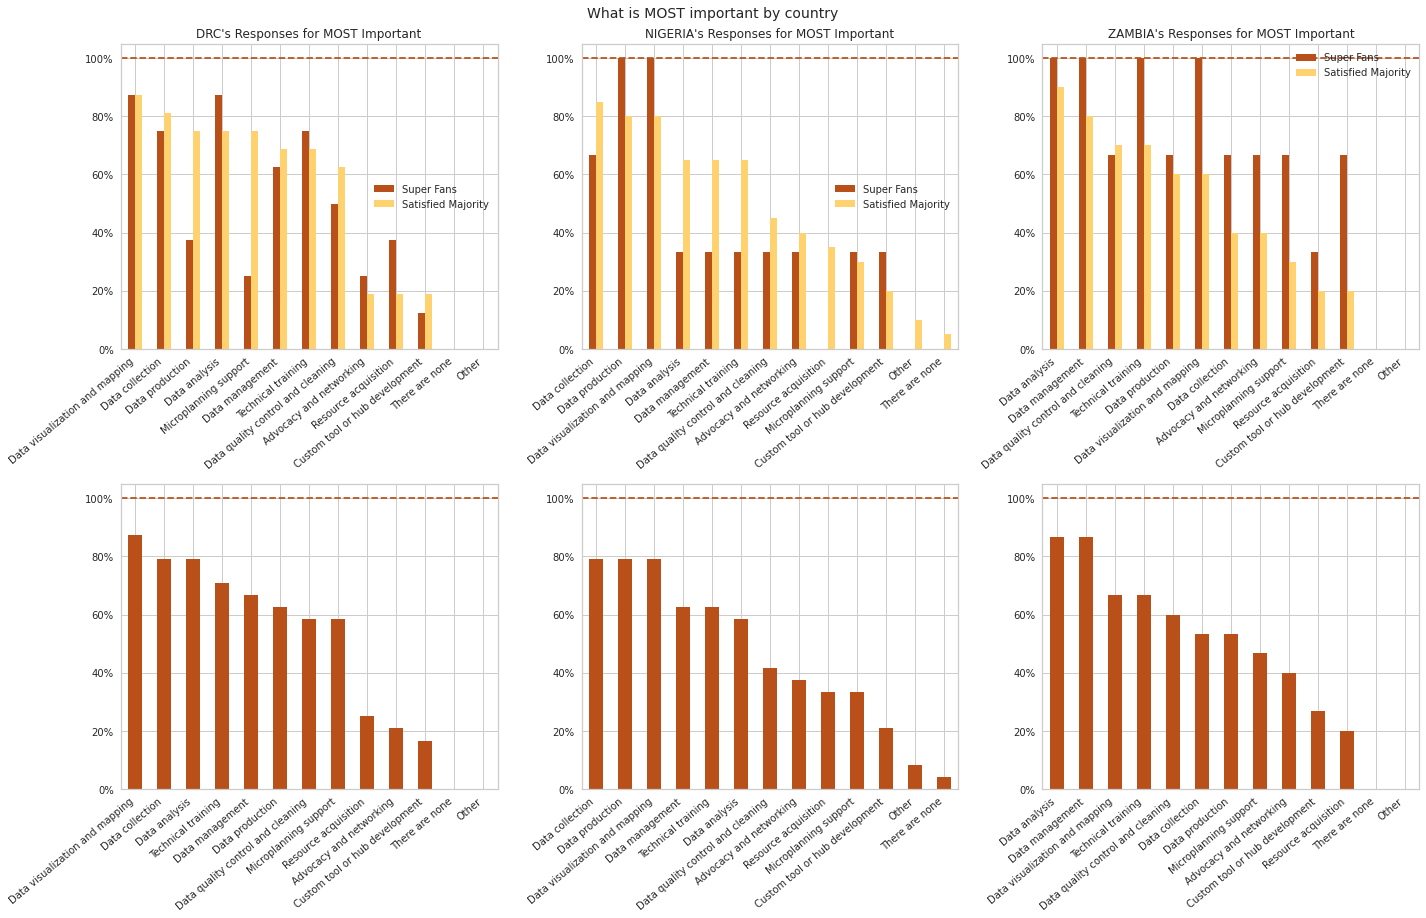

In [35]:
get_plots_by_country(most_important_df,"What is MOST important by country",'MOST')

#do not need these graphs

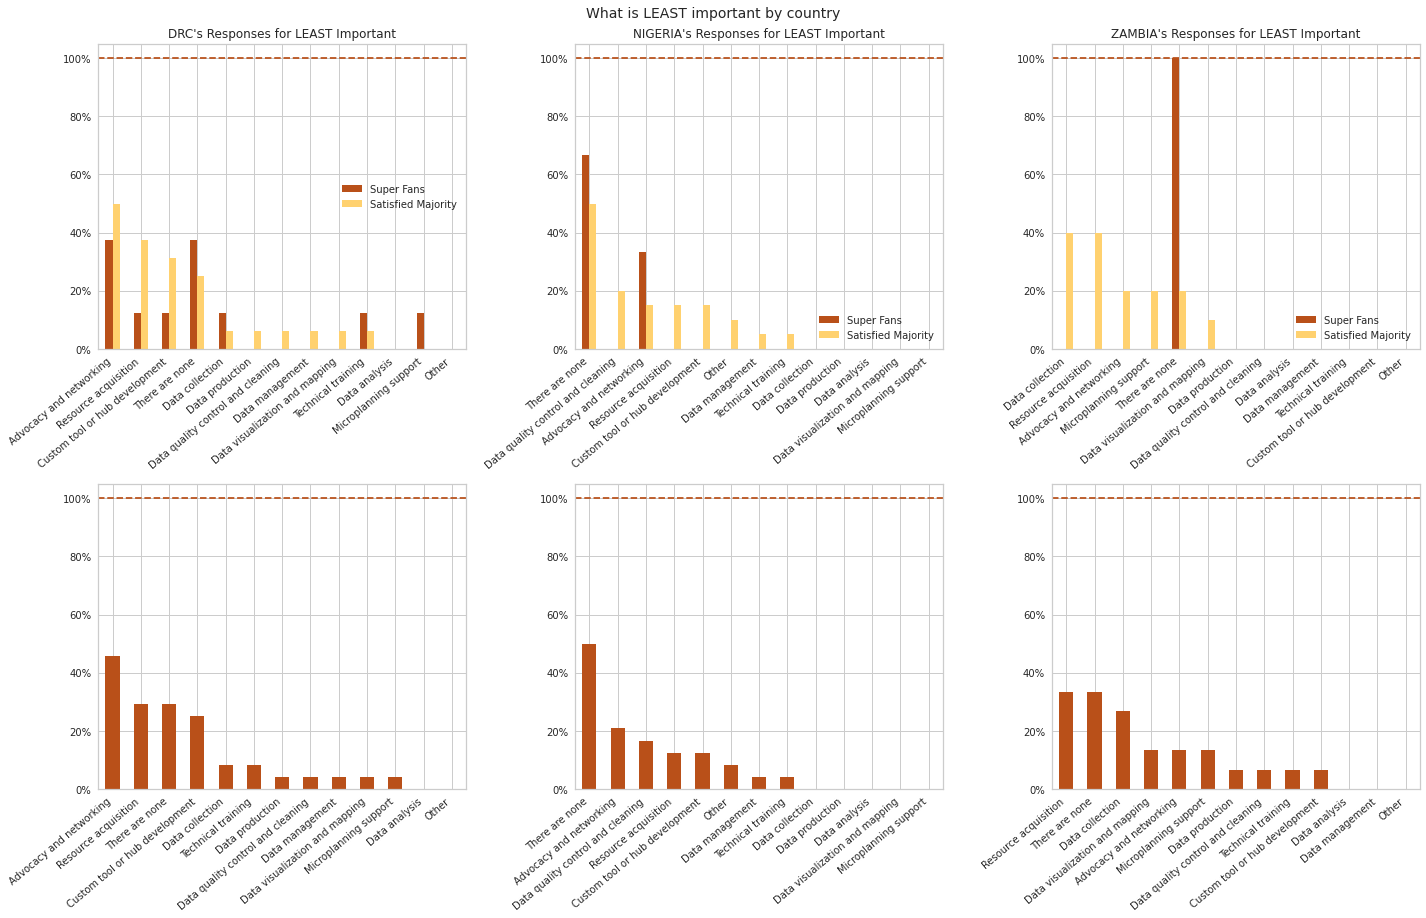

In [36]:
get_plots_by_country(least_important_df,"What is LEAST important by country","LEAST")

In [37]:
def get_plots(lst_dfs,title="No Title",subtitles="No Subtitle List",scale=1):
    fig, axs = plt.subplots(2,len(lst_dfs))
    
    for i,ax in zip(range(len(lst_dfs)*2),axs.ravel()):
        if i%2: #second row 
            try:
                plotting = lst_dfs[i//2].drop(columns=['labels','In which country do you work?']).mean()
                plotting.T.sort_values(ascending=False).plot(kind='bar',color=['#b95019'],ax=axs[i%2,i//2],ylim=[0,scale+(scale/10)],figsize=(16,12)).set_xticklabels(plotting.T.sort_values(ascending=False).index, rotation=40, ha='right')
            except:
                plotting = lst_dfs[i//2].drop(columns=['labels','In which country do you work?']).mean()
                print(plotting.head())
                plotting.T.sort_values(ascending=False).plot(kind='bar',color=['#b95019'],ax=axs[i%2],ylim=[0,scale+(scale/10)],figsize=(16,12)).set_xticklabels(plotting.T.sort_values(ascending=False).index, rotation=40, ha='right')
        else: #first row
            try:
                plotting = lst_dfs[i//2].drop(columns='In which country do you work?').groupby(['labels']).mean()
                plotting.T[["Super Fans","Satisfied Majority"]].sort_values('Satisfied Majority',ascending=False).plot(kind='bar',color=['#b95019','#ffd16f'],ax=axs[i%2,i//2],ylim=[0,scale+(scale/10)],figsize=(20,14)).set_xticklabels(plotting.T.sort_values('Satisfied Majority',ascending=False).index, rotation=40, ha='right')                    
            except:
                plotting = lst_dfs[i//2].drop(columns='In which country do you work?').groupby(['labels']).mean()
                plotting.T[["Super Fans","Satisfied Majority"]].sort_values('Satisfied Majority',ascending=False).plot(kind='bar',color=['#b95019','#ffd16f'],ax=axs[i%2],ylim=[0,scale+(scale/10)],figsize=(16,12)).set_xticklabels(plotting.T.sort_values('Satisfied Majority',ascending=False).index, rotation=40, ha='right')
        if i<len(lst_dfs):
            try:
                ax.set_title(subtitles[i])
            except:
                ax.set_title("No Title")
        ax.axhline(y=scale,c='#b95019',ls='--')
        if scale==1:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
            
        ax.set_ylabel("Average User Scores")

    
    return fig,axs

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


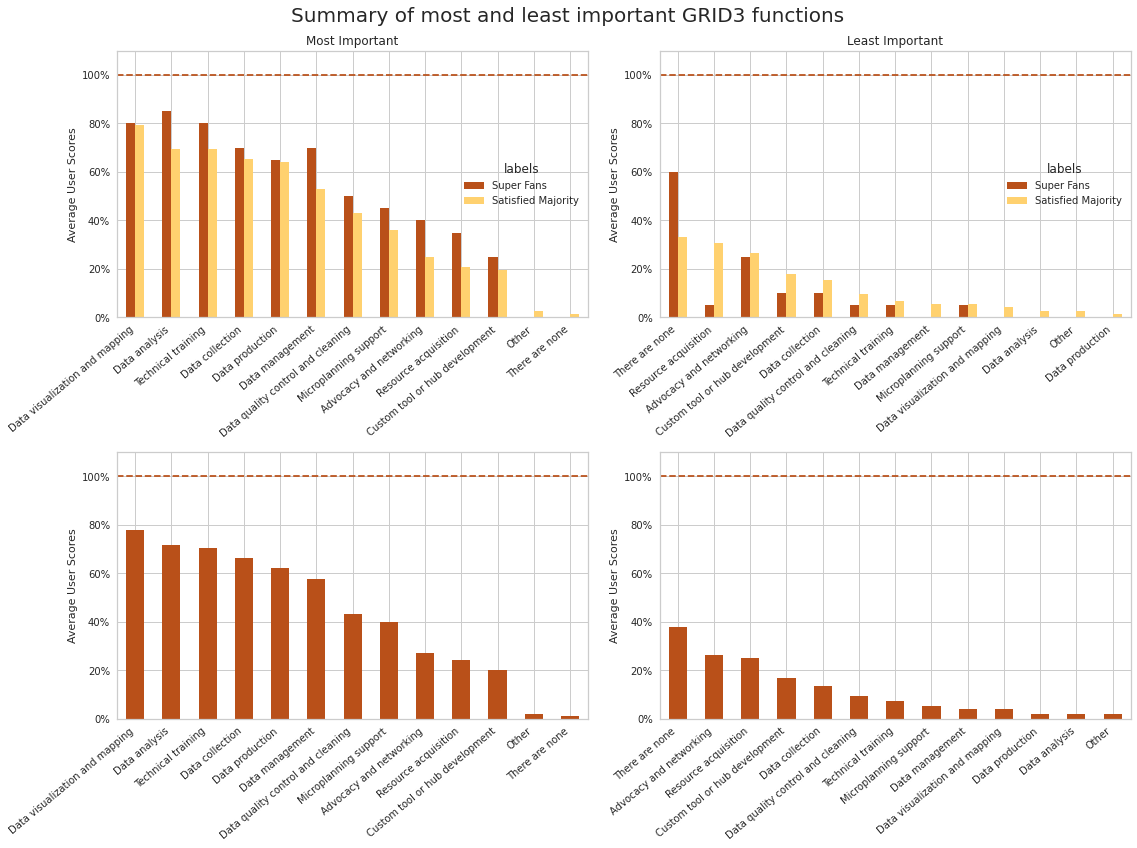

In [39]:
lst_dfs = [most_important_df,least_important_df]
lst2_dfs = [advertising_df]

fig,ax = get_plots(lst_dfs,"Summary of most and least important GRID3 functions",["Most Important","Least Important"])

fig.suptitle("Summary of most and least important GRID3 functions", fontsize = 20)
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()
plt.savefig("most_least_important.png")
plt.show()

Now that we have an overview of what the consumers beleive, we can take a *Net Positivity* analysis by substracting the positive from the negatives to find what are the most 'net positive' attributes of GRID3.

These graphs summarize what is the most and least important to our end users. On each graph, the Y-axis represents the percent of respondents *(100% means that everyone thinks a category is important or not important)*, the X-axis details which particular component individuals chose to be the most (or least) important. Finally each bar represents the percent of respondents who agree that a particular compoenent is the most (or least) important part of GRID3's efforts. The first 6 items on the X axis for each graph is directly data related, and everything that follows are other GRID3 efforts. Amongst those who have used GRID3 products...

#### Most Important
Within "Data-related" work, the highest items are:

1. Visualization and Mapping
2. Analysis 
3. Technical training
4. Data Collection
5. Data Production

Between the clusters, the sentiments seems consistent.

#### Least Important
Within "Data-related" work, the least important are:

1. Advocacy and networking 
2. Resource Aquisition
3. Custom Tool or Hub Development
4. Data Collection
5. Data Quality and Cleaning

That being said, the least important items are on a far smaller scale than the important items. That is to say, while around 70% of the users beleive Data Collection is important, only around 15% think its un

Between the clusters, both clusters beleive that *Advocacy and Networking* is the least important, where as the critical users uniquely believe that *Resource Aquisition* is non-important part of GRID3.

Finally it is worth noting that **40%** of the overall population believe that there are no-unimportant aspects of GRID3.

In [40]:
get_plots(

SyntaxError: unexpected EOF while parsing (2452262512.py, line 1)

GRID3 newsletter    0.197080
GRID3 website       0.562044
Linkedin            0.102190
Twitter             0.021898
Youtube             0.036496
dtype: float64


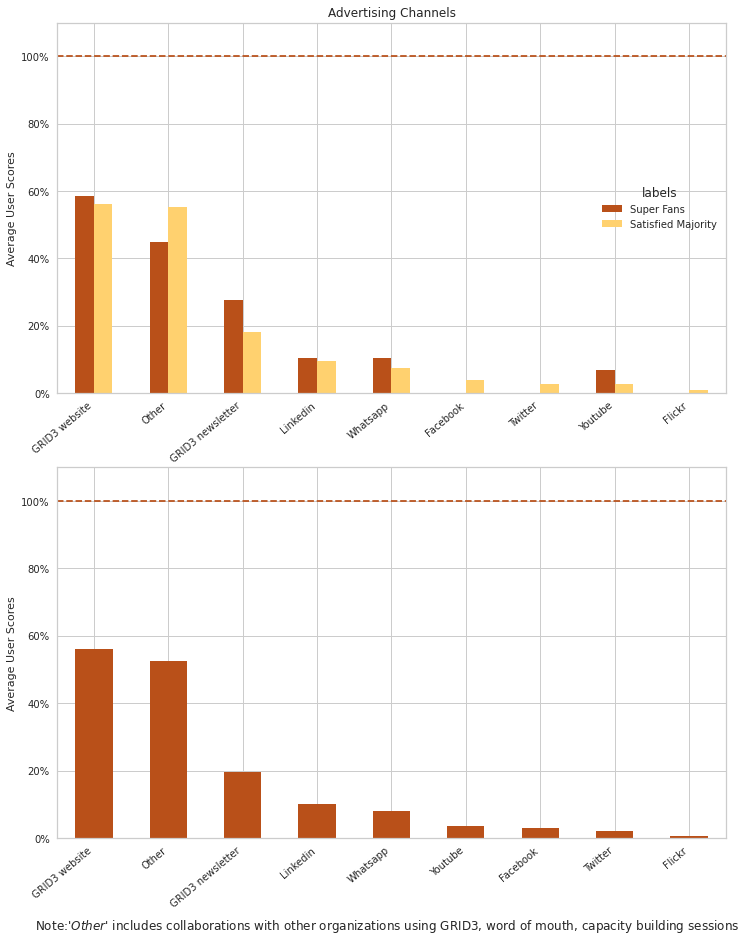

In [41]:
fig,ax = get_plots(lst2_dfs,"Summary advertising channels",["Advertising Channels"])

fig.set_size_inches(12,15)
fig.text(0.1,0.04,r"Note:'$\it{Other}$' includes collaborations with other organizations using GRID3, word of mouth, capacity building sessions")
fig.savefig("ad_channels.png")

#### \* Regarding Advertising Channels, most of the "Others" cateogry consists mainly of:
1. GRID3/QGIS training with their organizations and universities
3. Partnerships/collaborations with other oganizations that already uses GRID3
2. Word-of-mouth/email communcation with collegues and staff

Similar to the collection of graphs above, the Y-axis on each of the graphs represent percent of respondents, the X-axis details a particular responses from individuals, and the bars represent what percent of users responded to the question with a particular answer.

#### Barriers to Entry
The top barriers to entry on average is:
1. Lack of skills to use to geospatial software
2. Decision-making and integration of producst into workflows
and approximately tied for 3rd are Ownership and licensing, resources to print maps, and access to geospatial software.

There are some notable differences between fans and criticals.
1. The term "Inaccuracy of products" are completely driven by critical users
2. Relatively, fans beleive that the lack of access to software is more of a painpoint, where as critical users beleive it is the *skills* associated with accessing the software is more of a painpoint.
3. A large and disproportionate painpoint of fans is the lack of ownership or liscencing of product relative to critical users.

#### Utilization
The top use cases of GRID3 products are:
1. Population estimates
2. Settlement extents
3. Healthcare facility locations
4. Boundary data

Generally, the fans have a higher response rate for all categories except population estimates and projections, where both clusters have similar proportions.

#### Advertisement
The top channels where individuals get to know GRID3 products are (by far):
1. GRID3 Website
2. GRID3 Newsletter
3. Other (Training, Partnerships between organizations that use GRID3, Word-of-mouth)

The fans and critical users have generally the same proportions.

### Do you Agree with the following statements generally?

In [42]:
filtered_ranking_df = ranking_df[ranking_df['labels'] != 1]

In [43]:
def get_pie(lst_cols,lst_titles,figsize=(15,15),counts=[None]):
    fig, axes = plt.subplots(1,len(lst_cols),figsize=figsize)


    for ax,col,title,count in zip(axes,lst_cols,lst_titles,counts):

        gp = filtered_ranking_df.loc[:,col].value_counts(normalize=True)

        graphing = [gp.iloc[0:2].sum(),gp.iloc[2:4].sum()]
        labs = ["Strongly Agree or Agree","Neutral to Strongly Disagree"]

        ax.pie(x=graphing,labels=labs,
                colors=[GRID3_ORANGE,GRID3_PALE],
                autopct='%1.1f%%',
                explode=(0,0.1),
                shadow=True)
        ax.set_title(title,fontsize=12)
        ax.text(1,-.8,fr'$n={count}$')

    return fig, axes

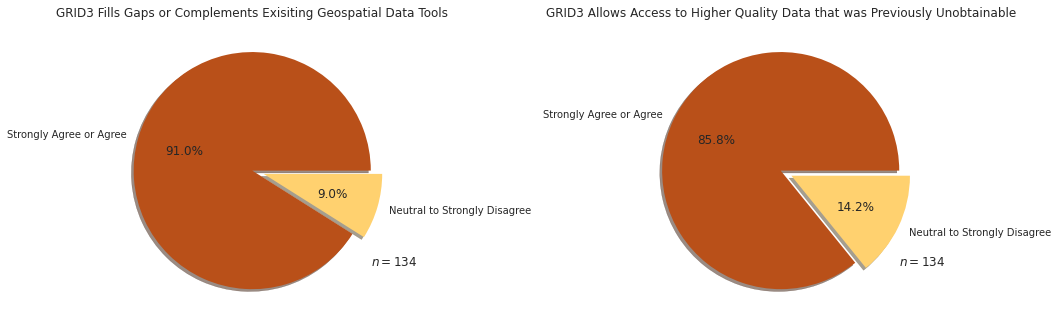

In [44]:
fig, axes = get_pie(['GRID3 fills gaps or complements existing mechanisms for geospatial data collection, creation, and production',"GRID3 enables stakeholders to access geospatial information that is of a higher quality (or otherwise improved), than what is currently available outside the program"],['GRID3 Fills Gaps or Complements Exisiting Geospatial Data Tools','GRID3 Allows Access to Higher Quality Data that was Previously Unobtainable'],
                   counts=[134,134])
fig.tight_layout(pad=2)
plt.savefig('fills_gaps_high_quality_pie.png')


### Comments:

These graphs show the responses for the questions surrounding GRID3's quality and its positioning relative other possible data providers. The Y-axis shows the proportion of individuals who responded to the question, the X-axis shows the rating (higher is better) that users gave in response to the question, and each bar represents the proportion of individuals who responded to this question with a particular response. 

We see here that generally, almost all individuals beleive that GRID3 products compliment existing workflows as well as provides high quality information.

## User Start Dates with GRID3

In [45]:
col = ['When did you first start engaging with or using GRID3-supported products (geospatial data, analysis, maps)?','In which country do you work?']
time_df = pd.DataFrame(raw_df.loc[:,col].dropna())
time_df['ordinal']=[x.toordinal() for x in time_df.iloc[:,0]]

In [46]:
time_df['year'] = time_df["When did you first start engaging with or using GRID3-supported products (geospatial data, analysis, maps)?"].apply(lambda x: x.year)

In [47]:
time_df.year

0      2022
3      2021
5      2020
6      2020
7      2021
       ... 
126    2022
128    2020
131    2021
133    2022
134    2022
Name: year, Length: 102, dtype: int64

In [48]:
time_df.groupby("year").size()[:5]

year
2017     4
2018     9
2019    16
2020    20
2021    32
dtype: int64

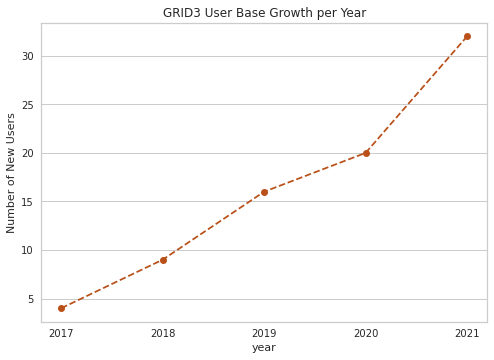

In [50]:
fig, ax = plt.subplots()

gp = time_df.groupby("year").size()[:5].fillna(0)
gp.plot(color=GRID3_ORANGE,ax=ax,style='--o')
ax.grid(axis='x')
ax.set_xticks(gp.index)
ax.set_ylabel("Number of New Users")
ax.set_title("GRID3 User Base Growth per Year")
plt.savefig('user_growth.png')
plt.show()

In [51]:
top_countries = raw_df['In which country do you work?'].value_counts()[:4].index

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


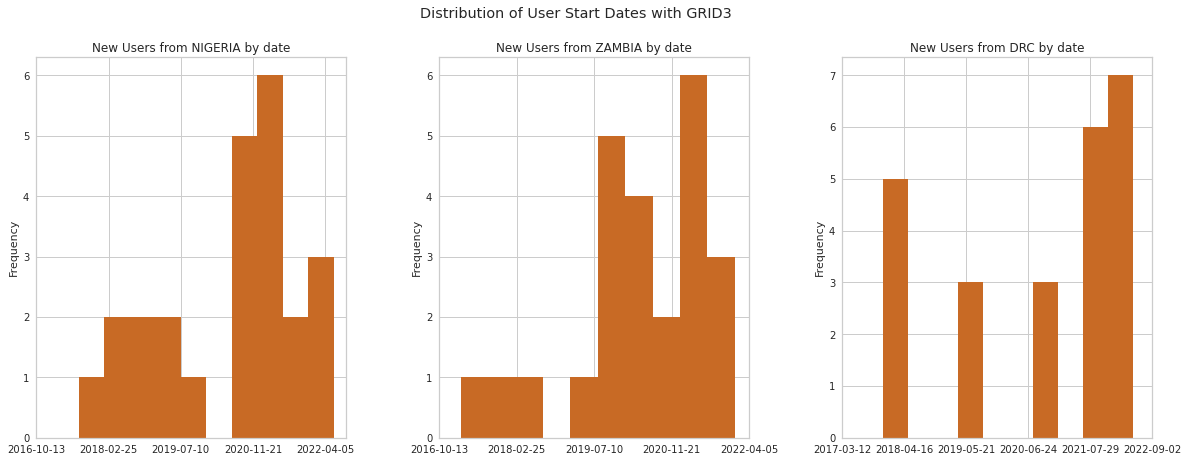

In [52]:
fig, axes = plt.subplots(1,3,figsize=(20,7))

for i,ax in enumerate(axes.ravel()):
    plotting = time_df[time_df['In which country do you work?'] == top_countries[i]]
    plotting['ordinal'].plot(kind='hist',color=['#c86a25'],ax=ax)
    x_ticks = ax.get_xticks()
    ax.set_xticks(x_ticks[::2])
    x_labs = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
    ax.set_xticklabels(x_labs)
    ax.set_title(f'New Users from {top_countries[i].upper()} by date')
    
plt.suptitle("Distribution of User Start Dates with GRID3")
plt.subplots_adjust(wspace=0.3,hspace=0.5)
plt.show()

#dont need these

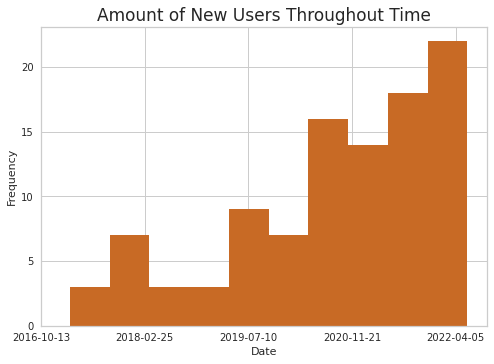

In [53]:
ax = time_df['ordinal'].plot(kind='hist',color=['#c86a25'])
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
x_labs = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(x_labs)
ax.set_title("Amount of New Users Throughout Time",fontsize=17,font='DejaVu Sans')
ax.set_xlabel("Date")
plt.show()

#need these

### Comments:

This graph shows the amount of new GRID3 users on a particular date. The Y-Axis is how many individuals are there, the X-Axis indicates the date, going from the past (left) to the future (right). The individual bars show how many new users started using GRID3 products at a particular date indicated on the X-Axis.

We see that generally, those who responded to our survey are mostly recent users. Note that this may (or may not!) reflect the actual population distritbuion of new users.

## Accuracy and Usability of various GRID3 tools in different use cases

In [68]:
relative_rankings = ranking_df.loc[:,'How accurate are the dataset(s), relative to other similar geospatial data?':'How useful are GRID3-supported health catchment area datasets, relative to other geospatial health catchment area data?']
ranking_df = ranking_df.rename(columns={"How would you characterize the user-experience (ease of use, design, relevance) of GRID3-supported hubs, relative to other data hubs?":"Hub Rating"})

In [69]:
relative_accuracies = relative_rankings.iloc[:,::2].join(raw_df.iloc[:,0])
relative_usefulness = relative_rankings.iloc[:,1::2].join(raw_df.iloc[:,0])
map_rankings = ranking_df.loc[:,'The maps make work efficient':"Hub Rating"].join(labels_col).join(raw_df.iloc[:,0])
relative_accuracies = relative_accuracies.join(labels_col)
relative_usefulness = relative_usefulness.join(labels_col)
clean_columns2(relative_accuracies,r'(are|is) (.*),')
clean_columns2(relative_usefulness,r'(are|is) (.*),')

In [70]:
def clean_columns2(labeled_df,regex_expr=r'/(.*)'):
    pattern = re.compile(regex_expr)
    
    columns_remap = {}
    for ele in labeled_df.dropna().drop(columns=['labels','In which country do you work?']).columns:
        columns_remap[ele] = pattern.search(ele).group(2).strip()

    labeled_df.rename(columns=columns_remap,inplace=True)

In [71]:
relative_rankings.shape

(134, 22)

In [74]:
relative_accuracies

,the dataset(s),GRID3-supported population estimates,GRID3-supported population projections,GRID3-supported settlement extents,GRID3-supported settlement names,GRID3-supported health facility locations,GRID3-supported school locations,GRID3-supported risk datasets,the GRID3-supported 'ease of social distancing' dataset,GRID3-supported boundary datasets,GRID3-supported health catchment area datasets,In which country do you work?,labels
0,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,NaN,3.0,NaN,ghana,Satisfied Majority
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zimbabwe,Satisfied Majority
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zimbabwe,Satisfied Majority
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,namibia,Satisfied Majority
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ethiopia,Satisfied Majority
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nigeria,Satisfied Majority
133,NaN,5.0,4.0,4.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0,sierra leone,Super Fans
134,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,4.0,NaN,sierra leone,Super Fans
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nigeria,Satisfied Majority


In [75]:
import functools as ft
a = relative_accuracies.drop(columns='labels').groupby('In which country do you work?')

lst = [a.get_group(x) for x in a.groups]

In [78]:
bundling_df = relative_accuracies.drop(columns=['labels','In which country do you work?']).count(axis=1).value_counts().sort_index()
bundling_df_segment = relative_accuracies.drop(columns=['In which country do you work?']).groupby('labels')
bundling_df_segment.groups
majority_df, fans_df = [bundling_df_segment.get_group(x) for x in bundling_df_segment.groups]
#fig, ax = plt.subplots()

maj_df = majority_df.drop(columns=['labels']).count(axis=1).value_counts().sort_index()
fans_df = fans_df.drop(columns=['labels']).count(axis=1).value_counts().sort_index()

bundling_df_segment = pd.merge(fans_df.rename('Super Fans'),maj_df.rename('Satisfied Majority'),left_index=True,right_index=True,how='outer').fillna(int(0))

bundling_df_segment.insert(loc=0,column='Total',value=bundling_df)


#ax.bar(bundling_df.index,bundling_df)

In [84]:
bundling_df = bundling_df.iloc[1:]

In [87]:
bundling_df_segment = bundling_df_segment.iloc[1:]

In [89]:
bundling_df_segment

,Total,Super Fans,Satisfied Majority
1,14,2.0,12
2,16,1.0,15
3,18,5.0,13
4,12,4.0,8
5,18,6.0,12
6,4,3.0,1
7,8,4.0,4
8,1,0.0,1
9,3,2.0,1
10,4,2.0,2


In [110]:
(bundling_df_segment.Total.iloc[2:].sum())/(bundling_df_segment.Total.sum()+35)

0.5149253731343284

In [91]:
bundling_df_segment.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

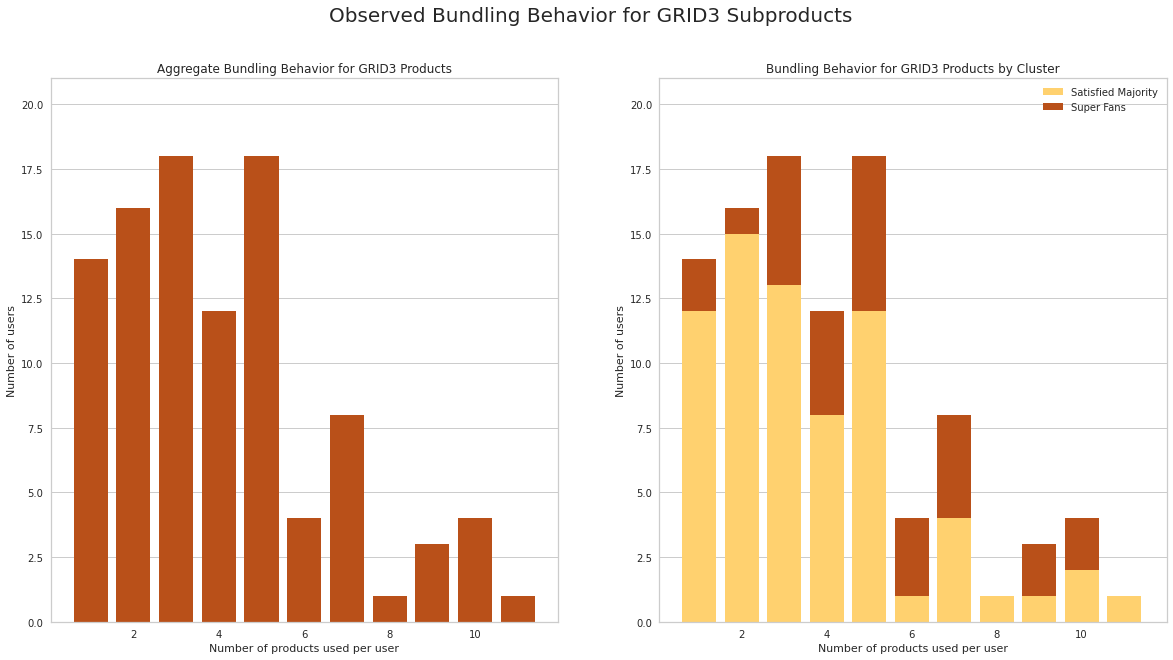

In [108]:
fig, axes = plt.subplots(1,2,figsize=(20,10))


axes[0].bar(bundling_df.index,bundling_df,color=[GRID3_ORANGE])
axes[0].grid(axis='x')
axes[0].set_xlabel('Number of products used per user')
axes[0].set_ylabel('Number of users')
axes[0].set_title('Aggregate Bundling Behavior for GRID3 Products')
axes[1] = get_stacked_bars(axes[1],bundling_df_segment,'Number of products used per user', 'Number of users','Bundling Behavior for GRID3 Products by Cluster')
axes[1].set_xticks(bundling_df_segment.index[::2])
for ax in axes:
    ax.set_ylim([0,20+(20/20)])
    
fig.suptitle("Observed Bundling Behavior for GRID3 Subproducts",fontsize=20)
plt.savefig("bundling_behavior.png")
plt.show()

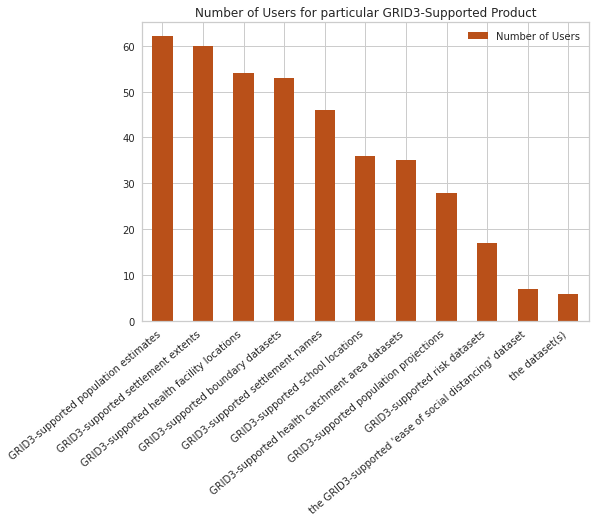

In [109]:
ax = pd.DataFrame(relative_accuracies.count().sort_values(ascending=False)).drop(['labels','In which country do you work?']).rename(columns={0:'Number of Users'}).plot(kind='bar',color=GRID3_ORANGE)

x_labs = ax.get_xticklabels()
ax.set_xticklabels(x_labs,rotation=40,ha='right')
plt.title('Number of Users for particular GRID3-Supported Product')
plt.show()

### Comments:

This graph shows the frequency of users for different GRID3 Supported Products. On the Y-axis we have the number of users; the X-axis indicates which particular GRID3 product the user utilized, and each of the bars indiciate how many respondents used a particular GRID3 product.

We see that the **most** utilized products are 
1. Population estimates
2. Settlement extents
3. Health Facility datasets
4. Boundary datasets

In [ ]:
fig,axes = get_plots([relative_accuracies,relative_usefulness],"Summary",["Accuracy","Usefulness","Map Usefulness"],scale=5)

fig.tight_layout(pad=3)


### Comments:

These graphs above (from left to right) shows the average score where users rank how accurate and useful GRID3 products are, wrapping up with overall comments on the maps GRID3 provide. The Y-axis indicates the average score individuals chose, the X-axis indicate how users rated a particular part of the GRID3 product mix **(higher is better)**. Lastly the individual bars on the top row (two different colors) are the average scores given by the Fans and the Critics shown together, the bars on the bottom row is the aggregate average of all users.

We see that in general, users tend to be quite consistent with each particular segment of GRID3's product mix, not necessarily indicating that one is worse or better than others.

## Efficacy of GRID3 Tools Supporting Project Decision Making and Likelihood of Future Use

In [ ]:
filtered_ranking_df.loc[:,'How likely are you to use GRID3-supported products (geospatial data, maps, analyses) in the future?'].value_counts()

In [ ]:
fig, axes = get_pie(['GRID3-supported products correctly identify the intended target **locations** for my organization’s program or service',
                            "GRID3-supported products correctly identify the intended target **population** for my organization’s program or service",
                           'How likely are you to use GRID3-supported products (geospatial data, maps, analyses) in the future?'],
                    ['GRID3-supported Products Correctly Identified Target Locations','GRID3-supported Products Correctly Identifed Target Populations','Users will Continue to Use GRID3 Products in the Future'],
                   figsize=(20,20),counts=[99,99,134])
fig.tight_layout(pad=2)
plt.savefig('accuracy_likely_to_use.png')


### Comments:

In the graphs above (from left to right), users who used GRID3 products rate whether GRID3 products were effective in helping them achieve their goal of identifying target locations, target populations, and concluding with whether or not individuals would like to use this in the future.

We see that most individuals indicate that GRID3 products have a generally positive impact in helping them identify target locations and populations, where nearly all of them indicate that they would like to use GRID3 products in the future.

### Comments: 

In the **final comments section**, some noteworthy data for constructive feedback include:

1. 'Data for Ethiopia is only settlement extent. The use will be enhanced if other data sets are available'
2. "GRID 3 should also make some courses available online at a leaner's pace ,and should be affordable especially for us in developing countries.",
3. "I think it's a very good project but just that we have to review the way of doing the recruitment especially the use of resources (take real cartographer) to avoid errors on the precision of data which is even the key and the success of the project."
4. 'GRID3 SHOULD PUT MORE EFFORTS TO REACH LOCAL LEVEL'
5. 'For me, GRID3 is a good structure that can improve mapping and several other things here in the DRC. Only, I suggest that GRID3 could associate the government so that in the long run, it becomes a property of the government like the DHIS2 for example. Also, for the accuracy, if possible add several other tools like drones etc which can really improve the quality of the maps and especially the accuracy. Finally, the maps and other data that GRID3 produces are so understandable even for non-mapping people (doctors, etc.) responsible for'
6. "we ask that you train the data managers of the province well how to create the map and how to use it"

Some other comments related to training are: 

7. 'the capacity building trainings in QGIS are of very good quality.'
8. 'really appreciated the training on the learning by doing method but I would like to continue the training and do the rest of the program.
9. 'My department does not use GRID3 for daily work but we have bases that can be imported and used there. In addition, I participated in online training and I received certificates of participation. However, there is not enough time to resume the exercises from the videos.'

and of course we can always pat ourselves on the back:

10. "This is a very good project for the DRC because it has made considerable progress in the country in its health mapping program, thanks to this intervention 50% of the country is now covered in data. I think that the country still needs this project to improve and produce the data and particularly to continue to support the country to finalize the production of health data for the whole country."
11.  'It is an important aspect for analysis considering the transformation into information, communication technology to adequately measure to provide solutions and predict the future outcome of socio-economic, political and environmental outcomes.'